In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyqg
from time import time
import os
import glob
from pyqg_generative.models.ols_model import OLSModel
from pyqg_generative.models.mean_var_model import MeanVarModel
from pyqg_generative.models.cgan_regression import CGANRegression
from pyqg_generative.tools.stochastic_pyqg import stochastic_QGModel
from pyqg_generative.tools.spectral_tools import spectrum
from pyqg_generative.tools.comparison_tools import *
import pyqg_parameterization_benchmarks as ppb
import json
%load_ext autoreload
%autoreload 3

/ext3/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pp2681/pyqg_experiments/pyqg_subgrid_experiments/__init__.py:19: UserWarning: Unable to load differentiable_parameterizations, install autograd if you want to use these
  warnings.warn("Unable to load differentiable_parameterizations, install autograd if you want to use these")


In [9]:
for folder in folder_iterator(return_blowup=True):
    nfiles = len(glob.glob(os.path.join(folder, '*.nc')))
    if nfiles < 10:
        print('Blow up experiment:', folder)
        print(nfiles)

Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/OLSModel/eddy-constant-0
7
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/CGANRegression/eddy-AR1-12
0
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/CGANRegression/eddy-AR1-24
0
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/CGANRegression/eddy-AR1-36
0
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/CGANRegression/eddy-AR1-48
0
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/CGANRegression/eddy-constant-0
0
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-32/MeanVarModel/eddy-AR1-12
0
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-32/MeanVarModel/eddy-AR1

In [66]:
highres = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/*.nc', combine='nested', concat_dim='run').load()
lowres = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc', combine='nested', concat_dim='run').load()

In [67]:
ds = coarsegrain_reference_dataset(highres, 64, 'Operator1')

var =  q
var =  u
var =  v
var =  psi


In [86]:
model = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/eddy-constant-0/*.nc', combine='nested', concat_dim='run')

In [122]:
%time ppb.diagnostic_similarities(model, ds, lowres, T=128)

CPU times: user 1min 10s, sys: 5.16 s, total: 1min 15s
Wall time: 1min 15s


{'distrib_diff_q1': 0.858958848737749,
 'distrib_diff_q2': 0.6829852218793004,
 'distrib_diff_u1': 0.8365561707176606,
 'distrib_diff_u2': 0.8359515205384592,
 'distrib_diff_v1': 0.8239561245227166,
 'distrib_diff_v2': 0.771637605692762,
 'distrib_diff_KE1': 0.8146259291083773,
 'distrib_diff_KE2': 0.7922537680920104,
 'distrib_diff_Ens1': 0.4273043973838644,
 'distrib_diff_Ens2': 0.9046362065639878,
 'spectral_diff_KEspec1': 0.7022520926440158,
 'spectral_diff_KEspec2': 0.7462702366351059,
 'spectral_diff_KEflux': 0.67189171244816,
 'spectral_diff_APEflux': 0.6747191576393875,
 'spectral_diff_APEgenspec': 0.7034482416054892,
 'spectral_diff_KEfrictionspec': 0.7462701065564776}

In [123]:
%time ppb.diagnostic_similarities(model, highres, lowres, T=1)

CPU times: user 4.36 s, sys: 187 ms, total: 4.55 s
Wall time: 4.35 s


{'distrib_diff_q1': 0.4782988103506248,
 'distrib_diff_q2': 0.5478571219381726,
 'distrib_diff_u1': 0.6549958889167478,
 'distrib_diff_u2': 0.5696289673682191,
 'distrib_diff_v1': 0.6647169852138799,
 'distrib_diff_v2': 0.6201911718994578,
 'distrib_diff_KE1': 0.6833885827469166,
 'distrib_diff_KE2': 0.5772909989774108,
 'distrib_diff_Ens1': 0.25183050288287756,
 'distrib_diff_Ens2': 0.615745445766283,
 'spectral_diff_KEspec1': 0.7022520686893807,
 'spectral_diff_KEspec2': 0.7462702061045448,
 'spectral_diff_KEflux': 0.6718916355424516,
 'spectral_diff_APEflux': 0.6747191837748199,
 'spectral_diff_APEgenspec': 0.7034481553888974,
 'spectral_diff_KEfrictionspec': 0.7462701927170194}

# Coarsegraining relative to all present filters

In [2]:
highres = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/*.nc', combine='nested', concat_dim='run').load()

In [3]:
for resolution in [32, 48, 64, 96]:
    for operator in ['Operator1', 'Operator2']:
        file = '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/'+operator+'-'+str(resolution)+'.nc'
        print(file)
        %time coarsegrain_reference_dataset(highres, resolution, operator).to_netcdf(file)

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-32.nc
CPU times: user 1min 17s, sys: 0 ns, total: 1min 17s
Wall time: 1min 17s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-32.nc
CPU times: user 1min 17s, sys: 119 ms, total: 1min 17s
Wall time: 1min 17s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
CPU times: user 1min 28s, sys: 591 ms, total: 1min 28s
Wall time: 1min 29s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-48.nc
CPU times: user 1min 28s, sys: 584 ms, total: 1min 29s
Wall time: 1min 29s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc
CPU times: user 1min 34s, sys: 916 ms, total: 1min 35s
Wall time: 1min 36s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
CPU times: user 1min 34s, sys: 930 ms, total: 1min 35s
Wall time: 1min 36s


In [2]:
similarity = {}
for model_folder, reference_folder, baseline_folder, key in folder_iterator(return_reference=True):
    model = xr.open_mfdataset(os.path.join(model_folder, '*.nc'), combine='nested', concat_dim='run').load()
    reference = xr.open_dataset(reference_folder).load()
    baseline = xr.open_mfdataset(baseline_folder, combine='nested', concat_dim='run').load()
    print(model_folder, reference_folder, baseline_folder, key, sep='\n')
    %time similarity[key] = ppb.diagnostic_similarities(model, reference, baseline, T=128)

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-0
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/*.nc
Operator1-48/OLSModel/eddy-constant-0
CPU times: user 39.6 s, sys: 2.2 s, total: 41.8 s
Wall time: 41.9 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-12
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/*.nc
Operator1-48/OLSModel/eddy-constant-12
CPU times: user 39.2 s, sys: 2.29 s, total: 41.5 s
Wall time: 41.6 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-24
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
/scratch/pp2681/pyqg_generative/Reference-

CPU times: user 39.6 s, sys: 1.11 s, total: 40.7 s
Wall time: 40.8 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/OLSModel/eddy-constant-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-48.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/*.nc
Operator2-48/OLSModel/eddy-constant-36
CPU times: user 39.7 s, sys: 546 ms, total: 40.3 s
Wall time: 40.4 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/OLSModel/eddy-constant-48
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-48.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/*.nc
Operator2-48/OLSModel/eddy-constant-48
CPU times: user 40 s, sys: 1.28 s, total: 41.3 s
Wall time: 41.5 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/MeanVarModel/eddy-AR1-12
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/ref

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/OLSModel/eddy-constant-12
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc
Operator1-64/OLSModel/eddy-constant-12
CPU times: user 1min 19s, sys: 3.25 s, total: 1min 22s
Wall time: 1min 23s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/OLSModel/eddy-constant-24
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc
Operator1-64/OLSModel/eddy-constant-24
CPU times: user 1min 17s, sys: 2.09 s, total: 1min 19s
Wall time: 1min 20s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/OLSModel/eddy-constant-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc
/scratch/pp2681/pyqg_genera

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/eddy-constant-48
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc
Operator1-64/CGANRegression/eddy-constant-48
CPU times: user 1min 14s, sys: 3.04 s, total: 1min 17s
Wall time: 1min 17s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/OLSModel/eddy-constant-0
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc
Operator2-64/OLSModel/eddy-constant-0
CPU times: user 1min 13s, sys: 4.29 s, total: 1min 17s
Wall time: 1min 18s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/OLSModel/eddy-constant-12
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
/scratch/pp2681/p

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/CGANRegression/eddy-constant-24
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc
Operator2-64/CGANRegression/eddy-constant-24
CPU times: user 1min 9s, sys: 4.37 s, total: 1min 13s
Wall time: 1min 14s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/CGANRegression/eddy-constant-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc
Operator2-64/CGANRegression/eddy-constant-36
CPU times: user 1min 10s, sys: 2.03 s, total: 1min 12s
Wall time: 1min 12s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/CGANRegression/eddy-constant-48
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.n

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/OLSModel/eddy-constant-12
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-96.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_96/*.nc
Operator2-96/OLSModel/eddy-constant-12
CPU times: user 3min 2s, sys: 10.3 s, total: 3min 12s
Wall time: 3min 13s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/OLSModel/eddy-constant-24
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-96.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_96/*.nc
Operator2-96/OLSModel/eddy-constant-24
CPU times: user 3min 2s, sys: 10.6 s, total: 3min 13s
Wall time: 3min 14s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/OLSModel/eddy-constant-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-96.nc
/scratch/pp2681/pyqg_generati

In [5]:
#with open('similarity.json', 'w') as file:
#    json.dump(similarity, file)

In [3]:
difference = {}
for model_folder, reference_folder, baseline_folder, key in folder_iterator(return_reference=True):
    model = xr.open_mfdataset(os.path.join(model_folder, '*.nc'), combine='nested', concat_dim='run').load()
    reference = xr.open_dataset(reference_folder).load()
    #baseline = xr.open_mfdataset(baseline_folder, combine='nested', concat_dim='run').load()
    print(model_folder, reference_folder, key, sep='\n')
    %time difference[key],_,_ = ppb.diagnostic_differences_Perezhogin(model, reference, T=128)

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/MeanVarModel/eddy-AR1-12
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-32.nc
Operator1-32/MeanVarModel/eddy-AR1-12
CPU times: user 7.92 s, sys: 493 ms, total: 8.41 s
Wall time: 8.45 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/MeanVarModel/eddy-AR1-24
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-32.nc
Operator1-32/MeanVarModel/eddy-AR1-24
CPU times: user 7.97 s, sys: 207 ms, total: 8.18 s
Wall time: 8.23 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/MeanVarModel/eddy-AR1-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-32.nc
Operator1-32/MeanVarModel/eddy-AR1-36
CPU times: user 8.07 s, sys: 41.6 ms, total: 8.12 s
Wall time: 8.16 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/MeanVarModel/eddy-A

KeyboardInterrupt: 

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/eddy-AR1-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Operator1-48/CGANRegression/eddy-AR1-36
CPU times: user 20.1 s, sys: 1.1 s, total: 21.2 s
Wall time: 21.4 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/eddy-AR1-48
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Operator1-48/CGANRegression/eddy-AR1-48
CPU times: user 20.1 s, sys: 884 ms, total: 21 s
Wall time: 21.1 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/eddy-constant-0
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Operator1-48/CGANRegression/eddy-constant-0
CPU times: user 20.3 s, sys: 378 ms, total: 20.7 s
Wall time: 20.8 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/OLS

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/MeanVarModel/eddy-AR1-24
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
Operator2-64/MeanVarModel/eddy-AR1-24
CPU times: user 37.4 s, sys: 2.19 s, total: 39.6 s
Wall time: 39.9 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/MeanVarModel/eddy-AR1-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
Operator2-64/MeanVarModel/eddy-AR1-36
CPU times: user 38.2 s, sys: 2.13 s, total: 40.4 s
Wall time: 40.6 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/MeanVarModel/eddy-AR1-48
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
Operator2-64/MeanVarModel/eddy-AR1-48
CPU times: user 37.3 s, sys: 2.24 s, total: 39.6 s
Wall time: 39.8 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/MeanVarModel/eddy-co

CPU times: user 1min 30s, sys: 6.17 s, total: 1min 37s
Wall time: 1min 37s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/CGANRegression/eddy-constant-0
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-96.nc
Operator2-96/CGANRegression/eddy-constant-0
CPU times: user 1min 31s, sys: 5.97 s, total: 1min 36s
Wall time: 1min 37s


In [14]:
difference = {}
for nfile in range(1,136):
    with open(f'difference/{nfile}.json', 'r') as file:
        d = json.load(file)
        key = d.pop('key')
        difference[key] = d

In [15]:
#with open('difference.json', 'w') as file:
#    json.dump(difference, file)

# Find best time sampling for each model

In [11]:
with open('similarity.json', 'r') as file:
    similarity = json.load(file)
with open('difference.json', 'r') as file:
    difference = json.load(file)

In [15]:
score_for_model(similarity, spectral_score, 64, 'Operator2', 'OLSModel')

{'Operator2-64/OLSModel/eddy-constant-0': -0.27476220370502813}

In [21]:
distrib_score(similarity['Operator2-64/OLSModel/eddy-constant-0'])

-1.3940893462392714

In [27]:
distrib_score(difference['Operator1-96/OLSModel/eddy-constant-0'])

0.0058487925495926485

In [19]:
distrib_score(difference['Operator2-64/Reference'])

0.056271641380205996

In [28]:
hires = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc')

Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/5b302d395d2e6e63.cache_netcdf


In [29]:
target = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc')
lores = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/[0-9].nc')
mse = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/OLSModel/eddy-constant-0/*.nc')
gz = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/MeanVarModel/eddy-constant-0/*.nc')
gan = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/eddy-constant-0/*.nc')
gan12 = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/eddy-AR1-12/*.nc')

Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/4f70657261746f72312d36342e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/5b302d395d2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/OLSModel/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/MeanVarModel/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/eddy-AR1-12/2a2e6e63.cache_netcdf


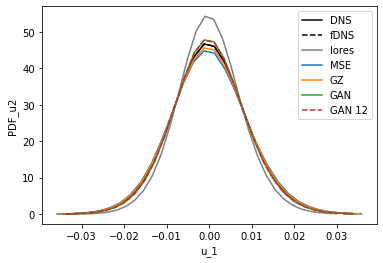

In [30]:
var = 'PDF_u2'
hires[var].plot(label='DNS', ls='-', color='k')
target[var].plot(label='fDNS', ls='--', color='k')
lores[var].plot(label='lores', color='gray')
mse[var].plot(label='MSE')
gz[var].plot(label='GZ', yscale='linear')
gan[var].plot(label='GAN', yscale='linear', xscale='linear')
gan12[var].plot(label='GAN 12', ls='--')
plt.legend()

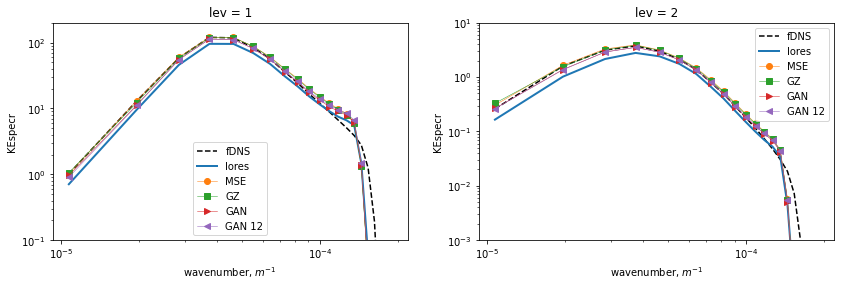

In [31]:
plt.figure(figsize=(14,4))
for lev in [0,1]:
    plt.subplot(1,2,lev+1)
    target.KEspecr.isel(lev=lev).plot(ls='--', color='k', label='fDNS')
    lores.KEspecr.isel(lev=lev).plot(lw=2, label='lores')
    mse.KEspecr.isel(lev=lev).plot(lw=0.5,marker='o', label='MSE')
    gz.KEspecr.isel(lev=lev).plot(lw=0.5,marker='s', label='GZ')
    gan.KEspecr.isel(lev=lev).plot(lw=0.5, label='GAN', marker='>', yscale='log', xscale='log')
    gan12.KEspecr.isel(lev=lev).plot(lw=0.5, label='GAN 12', marker='<', yscale='log', xscale='log')
    if lev==0:
        plt.ylim([1e-1, 2e+2])
    else:
        plt.ylim([1e-3, 1e+1])
    plt.legend()

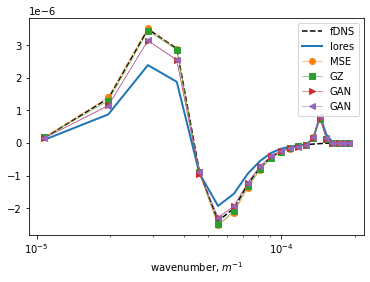

In [32]:
target.KEfluxr.plot(ls='--', color='k', label='fDNS')
lores.KEfluxr.plot(lw=2, label='lores')
(mse.KEfluxr+mse.paramspec_KEfluxr).plot(lw=0.5,marker='o', label='MSE')
(gz.KEfluxr+gz.paramspec_KEfluxr).plot(lw=0.5,marker='s', label='GZ')
(gan.KEfluxr+gan.paramspec_KEfluxr).plot(lw=0.5, label='GAN', marker='>', xscale='log')
(gan12.KEfluxr+gan12.paramspec_KEfluxr).plot(lw=0.5, label='GAN', marker='<', xscale='log')
plt.legend()

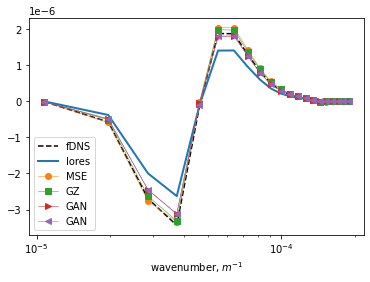

In [33]:
target.APEfluxr.plot(ls='--', color='k', label='fDNS')
lores.APEfluxr.plot(lw=2, label='lores')
(mse.APEfluxr+mse.paramspec_APEfluxr).plot(lw=0.5,marker='o', label='MSE')
(gz.APEfluxr+gz.paramspec_APEfluxr).plot(lw=0.5,marker='s', label='GZ')
(gan.APEfluxr+gan.paramspec_APEfluxr).plot(lw=0.5, label='GAN', marker='>', xscale='log')
(gan12.APEfluxr+gan12.paramspec_APEfluxr).plot(lw=0.5, label='GAN', marker='<', xscale='log')
plt.legend()

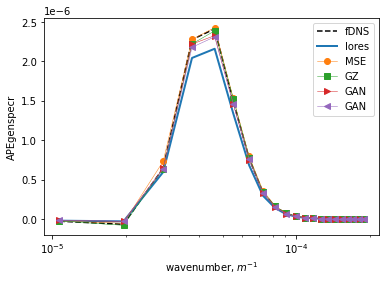

In [34]:
target.APEgenspecr.plot(ls='--', color='k', label='fDNS')
lores.APEgenspecr.plot(lw=2, label='lores')
mse.APEgenspecr.plot(lw=0.5,marker='o', label='MSE')
gz.APEgenspecr.plot(lw=0.5,marker='s', label='GZ')
gan.APEgenspecr.plot(lw=0.5, label='GAN', marker='>', xscale='log')
gan12.APEgenspecr.plot(lw=0.5, label='GAN', marker='<', xscale='log')
plt.legend()

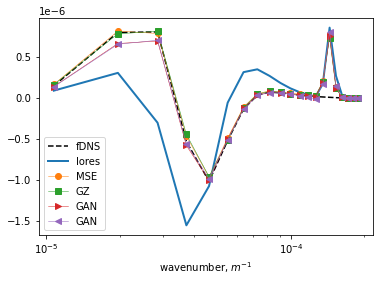

In [35]:
(target.KEfluxr+target.APEfluxr).plot(ls='--', color='k', label='fDNS')
(lores.KEfluxr+target.APEfluxr).plot(lw=2, label='lores')
(mse.KEfluxr+mse.paramspec_KEfluxr+mse.APEfluxr+mse.paramspec_APEfluxr).plot(lw=0.5,marker='o', label='MSE')
(gz.KEfluxr+gz.paramspec_KEfluxr+gz.APEfluxr+gz.paramspec_APEfluxr).plot(lw=0.5,marker='s', label='GZ')
(gan.KEfluxr+gan.paramspec_KEfluxr+gan.APEfluxr+gan.paramspec_APEfluxr).plot(lw=0.5, label='GAN', marker='>', xscale='log')
(gan12.KEfluxr+gan.paramspec_KEfluxr+gan12.APEfluxr+gan.paramspec_APEfluxr).plot(lw=0.5, label='GAN', marker='<', xscale='log')
plt.legend()

# New energy decomposition

In [37]:
def read_ds(path):
    ds = pse.Dataset(path)
    w = ds.relative_vorticity.compute()
    PV_advection = ds.advect(ds.u, ds.v, ds.q).compute()
    RV_advection = ds.advect(ds.u, ds.v, w).compute()
    PV_advection_to_RV = ds.PV_to_relative_vorticity(PV_advection).compute()
    E_flux = op.ave_lev(spectrum(type='cospectrum',averaging=True)(ds.psi, PV_advection),delta=0.25)
    KE_flux = op.ave_lev(spectrum(type='cospectrum',averaging=True)(ds.psi, RV_advection),delta=0.25)
    APE_flux = E_flux - KE_flux
    KE_contribution = op.ave_lev(spectrum(type='cospectrum',averaging=True)(ds.psi, PV_advection_to_RV),delta=0.25)
    APE_contribution = E_flux - KE_contribution
    return dict(E_flux=E_flux, KE_flux=KE_flux, APE_flux=APE_flux, KE_contribution=KE_contribution, APE_contribution=APE_contribution)

In [38]:
hires = read_ds('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/0.nc')

In [39]:
lores = read_ds('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc')

(1e-05, 0.0002)

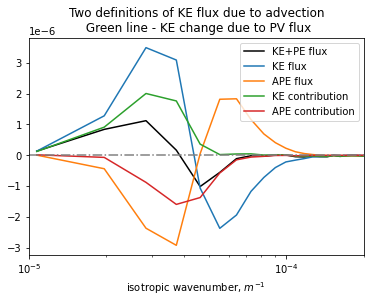

In [40]:
hires['E_flux'].plot(label='KE+PE flux', color='k')
hires['KE_flux'].plot(label='KE flux')
hires['APE_flux'].plot(label='APE flux')
hires['KE_contribution'].plot(label='KE contribution')
hires['APE_contribution'].plot(label='APE contribution', xscale='log')

plt.legend()
plt.title('Two definitions of KE flux due to advection\n Green line - KE change due to PV flux')
plt.axhline(y=0, ls='-.', color='gray')
plt.xlim([1e-5, 2e-4])

(1e-05, 0.0002)

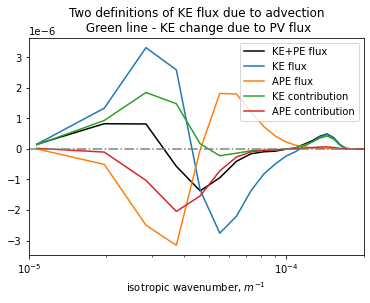

In [41]:
lores['E_flux'].plot(label='KE+PE flux', color='k')
lores['KE_flux'].plot(label='KE flux')
lores['APE_flux'].plot(label='APE flux')
lores['KE_contribution'].plot(label='KE contribution')
lores['APE_contribution'].plot(label='APE contribution', xscale='log')

plt.legend()
plt.title('Two definitions of KE flux due to advection\n Green line - KE change due to PV flux')
plt.axhline(y=0, ls='-.', color='gray')
plt.xlim([1e-5, 2e-4])

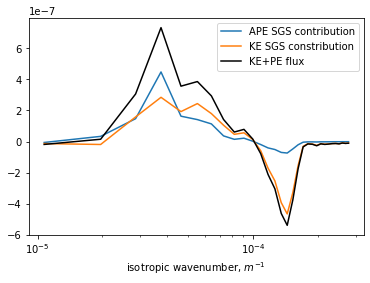

In [53]:
(hires['APE_contribution'] - lores['APE_contribution']).plot(xscale='log', label='APE SGS contribution')
(hires['KE_contribution'] - lores['KE_contribution']).plot(xscale='log', label='KE SGS constribution')
(hires['E_flux'] - lores['E_flux']).plot(label='KE+PE flux', color='k')
plt.legend()

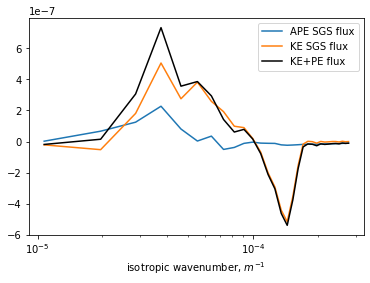

In [55]:
(hires['APE_flux'] - lores['APE_flux']).plot(xscale='log', label='APE SGS flux')
(hires['KE_flux'] - lores['KE_flux']).plot(xscale='log', label='KE SGS flux')
(hires['E_flux'] - lores['E_flux']).plot(label='KE+PE flux', color='k')
plt.legend()

# Ensemble forecasing metrics

In [2]:
operator = 'Operator1'
res = 48
dns = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/AR1-0/*.nc', combine='nested', concat_dim='run')
lores = xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/Reference/eddy-forecast/AR1-0/*.nc', combine='nested', concat_dim='run')

In [17]:
for operator, op_name in zip([op.Operator1, op.Operator2], ['Operator1', 'Operator2']):
    for res in [48, 64, 96]:
        fdns = xr.Dataset()
        for var in ['q', 'u', 'v', 'psi']:
            %time fdns[var] = operator(dns[var], res)
        fdns.to_netcdf(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/{op_name}-{str(res)}.nc')

CPU times: user 43.6 s, sys: 24.2 s, total: 1min 7s
Wall time: 1min 7s
CPU times: user 43 s, sys: 22.5 s, total: 1min 5s
Wall time: 1min 7s
CPU times: user 43.1 s, sys: 21.3 s, total: 1min 4s
Wall time: 1min 7s
CPU times: user 43.4 s, sys: 23.4 s, total: 1min 6s
Wall time: 1min 9s
CPU times: user 44.5 s, sys: 21.4 s, total: 1min 5s
Wall time: 1min 5s
CPU times: user 44.7 s, sys: 23.4 s, total: 1min 8s
Wall time: 1min 8s
CPU times: user 44.4 s, sys: 21.8 s, total: 1min 6s
Wall time: 1min 6s
CPU times: user 44.1 s, sys: 20 s, total: 1min 4s
Wall time: 1min 4s
CPU times: user 51.3 s, sys: 24.8 s, total: 1min 16s
Wall time: 1min 16s
CPU times: user 50.4 s, sys: 20.7 s, total: 1min 11s
Wall time: 1min 11s
CPU times: user 51.1 s, sys: 25.2 s, total: 1min 16s
Wall time: 1min 16s
CPU times: user 49.7 s, sys: 21.8 s, total: 1min 11s
Wall time: 1min 11s
CPU times: user 42.8 s, sys: 19.8 s, total: 1min 2s
Wall time: 1min 2s
CPU times: user 43.5 s, sys: 23.6 s, total: 1min 7s
Wall time: 1min 7s
CP

# Precompute spread and shape

In [454]:
gan = ensemble_dataset_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/CGANRegression/eddy-forecast/AR1-48/*.nc',
                     f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/{operator}-{str(res)}.nc')
gz = ensemble_dataset_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/MeanVarModel/eddy-forecast/AR1-48/*.nc',
                     f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/{operator}-{str(res)}.nc')

(1e-06, 200.0)

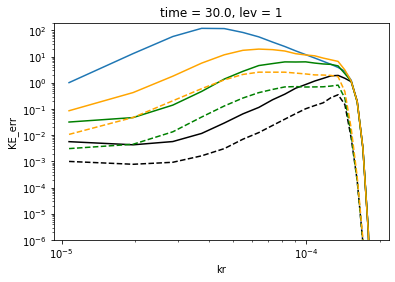

In [455]:
target = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc')
sp = spectrum(averaging=True, truncate=True)
(sp(target.u) + sp(target.v)).isel(lev=0).plot(xscale='log', yscale='log')
gan.KE_res.isel(time=5,lev=0).plot(ls = '--', color='k')
gan.KE_err.isel(time=5,lev=0).plot(color='k')
gan.KE_res.isel(time=15,lev=0).plot(ls = '--', color='g')
gan.KE_err.isel(time=15,lev=0).plot(color='g')
gan.KE_res.isel(time=30,lev=0).plot(ls = '--', color='orange')
gan.KE_err.isel(time=30,lev=0).plot(color='orange')
plt.ylim([1e-6, 2e+2])

(1e-06, 200.0)

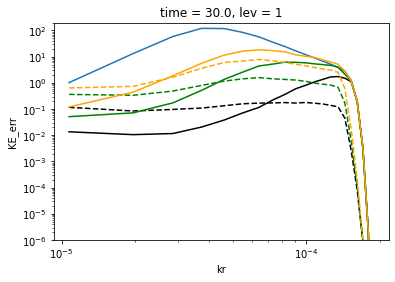

In [456]:
(sp(target.u) + sp(target.v)).isel(lev=0).plot(xscale='log', yscale='log')
gz.KE_res.isel(time=5,lev=0).plot(ls = '--', color='k')
gz.KE_err.isel(time=5,lev=0).plot(color='k')
gz.KE_res.isel(time=15,lev=0).plot(ls = '--', color='g')
gz.KE_err.isel(time=15,lev=0).plot(color='g')
gz.KE_res.isel(time=30,lev=0).plot(ls = '--', color='orange')
gz.KE_err.isel(time=30,lev=0).plot(color='orange')
plt.ylim([1e-6, 2e+2])

In [473]:
for operator in ['Operator1', 'Operator2']:
    for res in [48, 64, 96]:
        for decor in [0, 12, 24, 36, 48]:
            gan = ensemble_dataset_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/CGANRegression/eddy-forecast/AR1-{str(decor)}/*.nc',
                                 f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/{operator}-{str(res)}.nc')
            gz = ensemble_dataset_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/MeanVarModel/eddy-forecast/AR1-{str(decor)}/*.nc',
                                 f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/{operator}-{str(res)}.nc')
            print(operator, res, decor)

Operator1 48 0
Operator1 48 12
Operator1 48 24
Operator1 48 36
Operator1 48 48
Operator1 64 0
Operator1 64 12
Operator1 64 24
Operator1 64 36
Operator1 64 48
Operator1 96 0
Operator1 96 12
Operator1 96 24
Operator1 96 36
Operator1 96 48
Operator2 48 0
Operator2 48 12
Operator2 48 24
Operator2 48 36
Operator2 48 48
Operator2 64 0
Operator2 64 12
Operator2 64 24
Operator2 64 36
Operator2 64 48
Operator2 96 0
Operator2 96 12
Operator2 96 24
Operator2 96 36
Operator2 96 48


In [453]:
operator = 'Operator1'
res = 64
fdns = xr.open_dataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/{operator}-{str(res)}.nc', decode_times=False)
def coords(ds):
    ds['x'] = fdns['x']
    ds['y'] = fdns['y']
    return ds
lores = coords(xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/Reference/eddy-forecast/AR1-0/*.nc', combine='nested', concat_dim='run', decode_times=False))
mse = coords(xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/OLSModel/eddy-forecast/AR1-0/*.nc', combine='nested', concat_dim='run', decode_times=False))
gz = coords(xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/MeanVarModel/eddy-forecast/AR1-48/*.nc', combine='nested', concat_dim='run', decode_times=False))
gan = coords(xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/CGANRegression/eddy-forecast/AR1-48/*.nc', combine='nested', concat_dim='run', decode_times=False))

In [4]:
def plot_error(model, target, label, var='q', tmax=None):
    model = model.isel(time=slice(0,tmax))
    target = target.isel(time=slice(0,tmax))
    q_err = (model[var+'_mean'].astype('float64') - target[var].astype('float64'))
    q_spread = (model[var].astype('float64') - model[var+'_mean'].astype('float64'))
    normalize = (target[var].astype('float64')**2).mean(dim=('run', 'x', 'y')).isel(time=0)
    
    err = (q_err**2).mean(dim=('run', 'x', 'y')) / normalize
    spread = (q_spread**2).mean(dim=('run', 'x', 'y')) / normalize
    q_sq = (model[var].astype('float64')**2).mean(dim=('run', 'x', 'y')) / normalize
    q_mean_sq = (model[var+'_mean'].astype('float64')**2).mean(dim=('run', 'x', 'y')) / normalize
    
    plt.subplot(1,3,1)
    line, = err.isel(lev=0).plot(label=label, yscale='linear')
    spread.isel(lev=0).plot(ls='--', color=line._color)
    plt.subplot(1,3,2)
    err.isel(lev=1).plot(label=label, yscale='linear')
    spread.isel(lev=1).plot(ls='--', color=line._color)
    plt.subplot(1,3,3)
    q_sq.isel(lev=1).plot(label=label, yscale='linear')
    q_mean_sq.isel(lev=1).plot(ls='--', color=line._color)

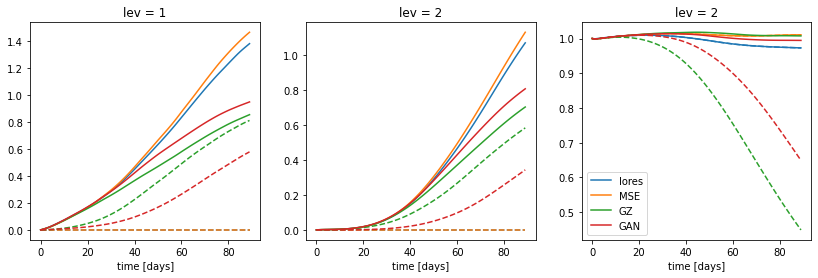

In [5]:
var = 'q'
tmax=90
plt.figure(figsize=(14,4))
plot_error(lores, fdns, 'lores', var, tmax)
plot_error(mse, fdns, 'MSE', var, tmax)
plot_error(gz, fdns, 'GZ', var, tmax)
plot_error(gan, fdns, 'GAN', var, tmax)
plt.legend()

In [4]:
sp = spectrum(averaging=True, truncate=True)

# spectrum of solution

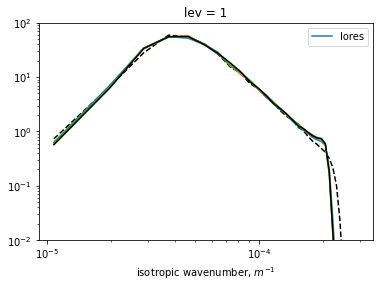

In [22]:
var = 'u'
lev=0
sp(fdns[var].isel(time=0)).isel(lev=lev).plot(color='k', ls='--')
sp(lores[var].isel(time=-1)).isel(lev=lev).plot(label='lores')
sp(mse[var].isel(time=-1)).isel(lev=lev).plot()
sp(gz[var].isel(time=-1)).isel(lev=lev).plot()
sp(gan[var].isel(time=-1)).isel(lev=lev).plot(color='k')
plt.yscale('log')
plt.xscale('log')
if var =='q':
    plt.ylim([1e-8, 1e-5])
elif var=='u' or var=='v':
    plt.ylim([1e-2, 1e+2])
elif var=='psi':
    plt.ylim([1e+7, 1e+12])
plt.legend()

# Spectrum of error and spread

In [2]:
def error(model, target, var, normalize=True):
    er = target[var] - model[var+'_mean']
    if normalize:
        return er / er.std(dim=('x', 'y', 'run'))
    else:
        return er
def spread(model, var, normalize=True):
    er = model[var] - model[var+'_mean']
    if normalize:
        return er / er.std(dim=('x', 'y', 'run'))
    else:
        return er

/ext3/miniconda3/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/ext3/miniconda3/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


([<matplotlib.axis.XTick at 0x15440941c3d0>,
 [Text(0, 0, ''), Text(0, 0, '')])

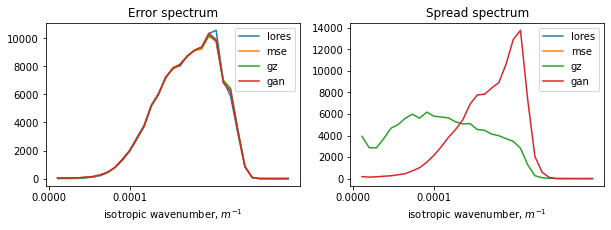

In [25]:
var = 'u'
lev=0
time=5
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
for model, name in zip([lores, mse, gz, gan], ['lores', 'mse', 'gz', 'gan']):
    sp(error(model,fdns,var).isel(time=time)).isel(lev=lev).plot(label=name)
plt.legend()
plt.title('Error spectrum')
plt.xticks([0, 1e-4])
plt.subplot(1,2,2)
for model, name in zip([lores, mse, gz, gan], ['lores', 'mse', 'gz', 'gan']):
    sp(spread(model,var).isel(time=time)).isel(lev=lev).plot(label=name)
plt.legend()
plt.title('Spread spectrum')
plt.xticks([0, 1e-4])

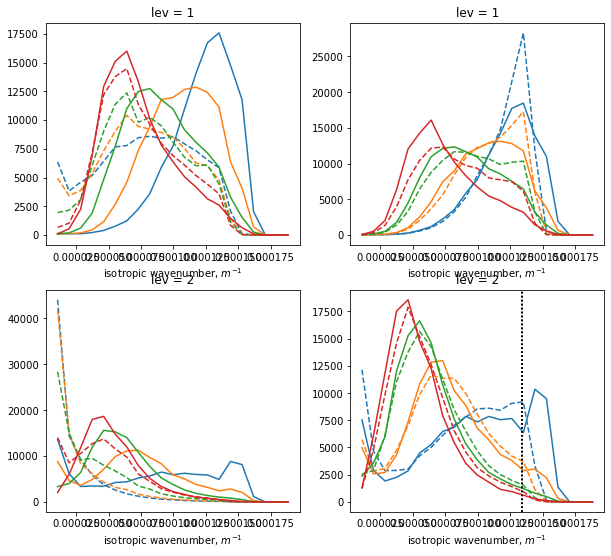

In [18]:
var = 'v'
normalize=True
plt.figure(figsize=(10,9))
for time in [5, 10, 20, 40]:
    
    plt.subplot(2,2,1)
    err = sp(error(gz,fdns,var,normalize).isel(time=time))
    spr = sp(spread(gz,var,normalize).isel(time=time))
    line, = err.isel(lev=0).plot()
    spr.isel(lev=0).plot(ls='--', color=line._color)
    plt.subplot(2,2,3)
    err.isel(lev=1).plot(color=line._color)
    spr.isel(lev=1).plot(ls='--', color=line._color)
    
    plt.subplot(2,2,2)
    err = sp(error(gan,fdns,var,normalize).isel(time=time))
    spr = sp(spread(gan,var,normalize).isel(time=time))
    line, = err.isel(lev=0).plot()
    spr.isel(lev=0).plot(ls='--', color=line._color)
    plt.subplot(2,2,4)
    err.isel(lev=1).plot(color=line._color)
    spr.isel(lev=1).plot(ls='--', color=line._color)
    
    dx = gz.x[2] - gz.x[1]
    kmax = np.pi/dx * 2/3
    plt.axvline(x=kmax, color='k', ls=':')